# 纯规范场（淬火近似）杂化 Monte Carlo

## 0 Markov chain Monte Carlo (MCMC)

根据格点上的路径积分形式，首先完成费米子部分积分
$$
\mathcal{Z}=\int\mathcal{D}U_\mu e^{-S_g(U_\mu)}\det\left[\mathcal{M}(U_\mu)\right]\\
\langle\mathcal{O}\rangle _\text{fermion}=\det\left[\mathcal{M}(U_\mu)\right]^{-1}\int\mathcal{D}\bar\psi\mathcal{D}\psi e^{-\bar\psi\mathcal{M}(U_\mu)\psi}\mathcal{O}\\
\langle\mathcal{O}\rangle=\frac{1}{\mathcal{Z}}\int\mathcal{D}U_\mu e^{-S_g(U_\mu)}\det\left[\mathcal{M}(U_\mu)\right]\langle\mathcal{O}\rangle _\text{fermion}
$$
其中 $\langle\mathcal{O}\rangle _\text{fermion}$ 部分可以通过在某个规范场组态（configuration）上进行测量得到。

现在考虑规范场积分步骤。显然 $U_\mu$ 的维数过于巨大，我们只能采用 Monte Carlo 方法进行数值积分。重点抽样可以极大程度增加积分的精度，因此我们希望有一些规范场满足分布
$$
\left\{U_\mu\right\}\sim\frac{1}{\mathcal{Z}}e^{-S_g(U_\mu)}\det\left[\mathcal{M}(U_\mu)\right]
$$
这样，我们只需要进行简单的对组态平均即可完成积分
$$
\frac{1}{\mathcal{Z}}\int\mathcal{D}U_\mu e^{-S_g(U_\mu)}\det\left[\mathcal{M}(U_\mu)\right]\langle\mathcal{O}\rangle _\text{fermion}\approx\frac{1}{N}\sum_{\left\{U_\mu\right\}}\langle\mathcal{O}\rangle _\text{fermion}
$$

对于纯规范场（淬火近似）的组态来说，有 $\det\left[\mathcal{M}(U_\mu)\right]=1$，上述分布退化到
$$
\mathcal{Z}=\int\mathcal{D}U_\mu e^{-S_g(U_\mu)},\;\left\{U_\mu\right\}\sim\frac{1}{\mathcal{Z}}e^{-S_g(U_\mu)}
$$
现在分布形式与统计力学中 Boltzmann 分布十分类似。这样我们可以通过 Markov 链 Monte Carlo 方法获得一些符合目标分布的规范场组态。

需要注意的是，通过 MCMC 径迹（trajectory）采样获得的样本之间存在自相关（autocorrelation），直接进行样本平均将会低估误差，需要额外的步骤降低影响。

## 1 初始化

### 1.1 导入需要的 Python 包

`exp` 和 `random` 用于判断是否接受新的规范场

`perf_counter` 函数用于记时

`pyquda` 包中的函数用于使用 GPU 加速格点 QCD 计算

`hmc` 包来自 `hmc.py`，主要是对 PyQUDA 函数的封装

In [1]:
from math import exp
from random import random
from time import perf_counter

from matplotlib import pyplot as plt

from pyquda_utils import core, io

from hmc import HMC

### 1.2 初始化 PyQUDA 并设置格子大小

调用 `init()` 初始化 PyQUDA，`resource_path` 指向存储调优参数的文件夹。

获取一个 `LatticeInfo` 实例用于之后的计算，这里我们设置了一个 $16^3\times32$ 的格子。

获取一个 `HMC` 实例并初始化。HMC 将 QUDA 函数包装为更易用的形式。

获取一个 `LatticeGauge` 实例用于存取每一步的规范场。

In [2]:
core.init(resource_path=".cache")
latt_info = core.LatticeInfo([16, 16, 16, 32])

hmc = HMC(latt_info)
hmc.initialize()

gauge = core.LatticeGauge(latt_info)
Nc = latt_info.Nc

PyQUDA INFO: Using the grid size [1, 1, 1, 1]
PyQUDA INFO: Using QUDA_RESOURCE_PATH=.cache
PyQUDA INFO: Using CUDA backend cupy
Disabling GPU-Direct RDMA access
Enabling peer-to-peer copy engine and direct load/store access
QUDA 1.1.0 (git 1.1.0-341431726-sm_60)
CUDA Driver version = 12020
CUDA Runtime version = 11080
Graphic driver version = 535.183.01
Found device 0: Tesla P100-PCIE-16GB
Found device 1: Tesla P100-PCIE-16GB
Found device 2: Tesla P100-PCIE-16GB
Found device 3: Tesla P100-PCIE-16GB
Using device 0: Tesla P100-PCIE-16GB
Initializing monitoring on device 0: Tesla P100-PCIE-16GB
cublasCreated successfully


### 1.3 设置规范作用量参数

### 1.3.0 分子动力学

首先我们有规范场 $U_\mu$，引入共轭动量 $\pi_\mu$，考虑 Hamiltonian
$$
\mathcal{H}=\frac{1}{2}\sum_{x,\mu}\mathrm{Tr}\left[\pi_\mu(x)\pi_\mu(x)\right]+\frac{\beta}{N_c}\sum_{x,\mu,\nu\gt\mu}\mathfrak{Re}\mathrm{Tr}\left[\mathbb{I}_{N_c}-U_\mu(x)A_{\mu,\nu}(x)\right]
$$
共轭动量 $\pi_\mu(x)\in\mathfrak{su}(3)$，为无迹 Hermitian 矩阵。

有 Hamiltonian 正则方程
$$
\frac{\mathrm{d}}{\mathrm{d}t}\pi_\mu(x)=-\frac{\partial S_g(U_\mu)}{\partial U_\mu(x)},\;\frac{\mathrm{d}}{\mathrm{d}t}U_\mu(x)=i\pi_\mu(x)U_\mu(x)
$$

我们希望通过分子动力学过程使得
$$
\{\pi_\mu,U_\mu\}\sim e^{-\mathcal{H}}=e^{-\frac{1}{2}\sum_{x,\mu}\mathrm{Tr}\left[\pi_\mu(x)\pi_\mu(x)\right]}e^{-\frac{\beta}{N_c}\sum_{x,\mu,\nu\gt\mu}\mathfrak{Re}\mathrm{Tr}\left[\mathbb{I}_{N_c}-U_\mu(x)A_{\mu,\nu}(x)\right]}
$$
显然 $\pi_\mu$ 和 $U_\mu$ 的分布是互相独立的。

#### 1.3.1 Wilson 规范作用量

$$
S_g(U_\mu)=\frac{\beta}{N_c}\sum_{x,\mu,\nu\gt\mu}\mathfrak{Re}\mathrm{Tr}\left[\mathbb{I}_{N_c}-U_\mu(x)U_\nu(x+\hat{\mu})U^\dagger_\mu(x+\hat{\nu})U^\dagger_\nu(x)\right]
$$

![plaquette](plaquette.drawio.svg)

对于一个由规范链接收尾相连组成的圈，总可以使用方向矢量来表示。例如上图的圈可以写成 $\mathrm{Tr}\left[U_\mu(x)U_\nu(x+\hat{\mu})U^\dagger_\mu(x+\hat{\nu})U^\dagger_\nu(x)\right]\sim\left[\mu,\nu,-\mu,-\nu\right]\text{ at }x$。

忽略常数项，Wilson 规范作用量记为
$$
S_g(U_\mu)=-\frac{\beta}{N_c}\sum_{x,\mu,\nu\gt\mu}\mathfrak{Re}\left[\mu,\nu,-\mu,-\nu\right]
$$

展开 $\sum_{\nu\gt\mu}$
$$
\begin{aligned}
S_g(U_\mu)=-\frac{\beta}{N_c}\sum_{x}\mathfrak{Re}\left\{\left[x,y,-x,-y\right]+\left[x,z,-x,-z\right]+\left[y,z,-y,-z\right]\right.\\
\left.+\left[x,t,-x,-t\right]+\left[y,t,-y,-t\right]+\left[z,t,-z,-t\right]\right\}
\end{aligned}
$$

我们使用 $0,1,2,3$ 来标记 $x,y,z,t$ 四个方向，$4,5,6,7$ 来标记相应的反方向
$$
\begin{aligned}
S_g(U_\mu)=-\frac{\beta}{N_c}\sum_{x}\mathfrak{Re}\left\{\left[0,1,4,5\right]+\left[0,2,4,6\right]+\left[1,2,5,6\right]\right.\\
\left.+\left[0,3,4,7\right]+\left[1,3,5,7\right]+\left[2,3,6,7\right]\right\}
\end{aligned}
$$

PyQUDA 会处理取实部操作，对于特定坐标 $x$，最终输入的作用量为
$$
\begin{aligned}
S'_g(U_\mu)=-\frac{\beta}{N_c}\left\{\left[0,1,4,5\right]+\left[0,2,4,6\right]+\left[1,2,5,6\right]\right.\\
\left.+\left[0,3,4,7\right]+\left[1,3,5,7\right]+\left[2,3,6,7\right]\right\}
\end{aligned}
$$

$$
\beta=\frac{2N_c}{g^2}
$$

In [3]:
u_0 = 0.855453
beta = 6.20
input_path = [
    [0, 1, 4, 5],
    [0, 2, 4, 6],
    [1, 2, 5, 6],
    [0, 3, 4, 7],
    [1, 3, 5, 7],
    [2, 3, 6, 7],
]
input_coeff = [
    -beta / Nc,
    -beta / Nc,
    -beta / Nc,
    -beta / Nc,
    -beta / Nc,
    -beta / Nc,
]

#### 1.3.2 Wilson 规范力

根据 Hamiltonian 正则方程
$$
\delta U_\mu(x)=i\pi_\mu(x)U_\mu(x)\delta t
$$

分子动力学积分需要 Hamiltonian（总能量）保持不变
$$
\delta H=0
$$

那么对某个特定位置 $x$ 的部分变分
$$
\begin{aligned}
0=&\sum_{\mu}\mathrm{Tr}\left[\delta\pi_\mu(x)\pi_\mu(x)\right]\\
&-\frac{\beta}{N_c}\sum_{\mu,\nu\ne\mu}\mathfrak{Re}\mathrm{Tr}\left[\delta U_\mu(x)A_{\mu,\nu}(x)+\delta U_\mu(x)A_{\mu,-\nu}(x)\right]\delta t\\
=&\sum_{x,\mu}\mathrm{Tr}\left[\delta\pi_\mu(x)\pi_\mu(x)\right]\\
&-\frac{\beta}{N_c}\sum_{x,\mu,\nu\ne\mu}\mathfrak{Re}\mathrm{Tr}\left[i\pi_\mu(x)U_\mu(x)A_{\mu,\nu}(x)+i\pi_\mu(x)U_\mu(x)A_{\mu,-\nu}(x)\right]\delta t\\
=&\sum_{x,\mu}\mathrm{Tr}\left[\delta\pi_\mu(x)\pi_\mu(x)\right]\\
&-\frac{\beta}{N_c}\sum_{x,\mu,\nu\ne\mu}\mathrm{Tr}\left\{i\pi_\mu(x)\left[U_\mu(x)A_{\mu,\nu}(x)+U_\mu(x)A_{\mu,-\nu}(x)\right]_\text{Traceless,Anti-Hermitian}\right\}\delta t
\end{aligned}
$$

$$
\begin{aligned}
&\mathfrak{Re}\mathrm{Tr}\left[i\pi_\mu(x)U_\mu(x)A_{\mu,\nu}(x)\right]\\
=&\frac{1}{2}\mathrm{Tr}\left[i\pi_\mu(x)U_\mu(x)A_{\mu,\nu}(x)-iA^\dagger_{\mu,\nu}U^\dagger_\mu(x)\pi_\mu(x)\right]\\
=&\mathrm{Tr}\left\{i\pi_\mu(x)\left[U_\mu(x)A_{\mu,\nu}(x)\right]_\text{Anti-Hermitian}\right\}
\end{aligned}
$$

![plaquette](plaquette.drawio.svg)

上式应当对任意的 $\pi_\mu(x)$ 成立
$$
\delta\pi_\mu(x)=\frac{\beta}{N_c}\sum_{\nu\ne\mu}i\left[U_\mu(x)A_{\mu,\nu}(x)+U_\mu(x)A_{\mu,-\nu}(x)\right]_\text{Traceless,Anti-Hermitian}\delta t
$$

QUDA 中动量场实际为 $i\pi_\mu$，对规范力添加了一个负号并应用无迹反 Hermitian 操作
$$
F'_g(x,U_\mu)=\frac{\beta}{N_c}\sum_{\nu\ne\mu}\left\{[\mu,\nu,-\mu,-\nu]+[\mu,-\nu,-\mu,\nu]\right\}
$$

以 $\mu=x$ 为例，按照之前约定使用数字代表方向，对于特定坐标 $x$，最终输入的规范力为
$$
\begin{aligned}
F'_g(U_\mu)=\frac{\beta}{N_c}\left\{[0,1,4,5]+[0,5,4,1]+[0,2,4,6]\right.\\
\left.+[0,6,4,2]+[0,3,4,7]+[0,7,4,3]\right\}
\end{aligned}
$$

In [4]:
input_path2 = [
    [
        [0, 1, 4, 5],
        [0, 5, 4, 1],
        [0, 2, 4, 6],
        [0, 6, 4, 2],
        [0, 3, 4, 7],
        [0, 7, 4, 3],
    ],
    [
        [1, 4, 5, 0],
        [1, 0, 5, 4],
        [1, 2, 5, 6],
        [1, 6, 5, 2],
        [1, 3, 5, 7],
        [1, 7, 5, 3],
    ],
    [
        [2, 4, 6, 0],
        [2, 0, 6, 4],
        [2, 5, 6, 1],
        [2, 1, 6, 5],
        [2, 3, 6, 7],
        [2, 7, 6, 3],
    ],
    [
        [3, 4, 7, 0],
        [3, 0, 7, 4],
        [3, 5, 7, 1],
        [3, 1, 7, 5],
        [3, 6, 7, 2],
        [3, 2, 7, 6],
    ],
]
input_coeff2 = [
    beta / Nc,
    beta / Nc,
    beta / Nc,
    beta / Nc,
    beta / Nc,
    beta / Nc,
]

### 1.4 设置 Markov 链（径迹）参数

Markov 链从 0 开始（单位场），总共运行 2000 步，前 500 步不考虑 Metropolis 算法而是直接接受，使得系统达到热平衡。

每一步的演化时间为 1.0，每次演化（分子动力学积分）分成 20 小步以降低积分误差。

In [5]:
start = 0
stop = 2000
warm = 500
save = 50
t = 1.0
n_steps = 20

## 2 HMC

### 2.1 输出初始状态统计信息

小方格（plaquette）作为最简单的可观测量，表征规范场势能。
$$
\text{Plaquette}(U_\mu)=\frac{1}{6VN_c}\sum_{x,\mu,\nu\gt\mu}\mathfrak{Re}\mathrm{Tr}\left[U_\mu(x)U_\nu(x+\hat{\mu})U^\dagger_\mu(x+\hat{\nu})U^\dagger_\nu(x)\right]
$$

In [6]:
plaquette = [hmc.plaquette()]
print("\n" f"Trajectory {start}:\n" f"plaquette = {plaquette[-1]}\n")


Trajectory 0:
plaquette = 1.0



### 2.2 第 1 步开始

计数器设置为 `start`。

In [7]:
i = start
s = perf_counter()
print(f"Trajectory {i + 1}:\n")

Trajectory 1:



### 2.3 根据 Gaussian 分布产生随机的共轭动量场

$$
\pi_\mu(x)\sim e^{-\frac{1}{2}\mathrm{Tr}\left[\pi_\mu(x)\pi_\mu(x)\right]}\\
\pi^\dagger_\mu(x)=\pi_\mu(x),\mathrm{Tr}\left[\pi_\mu(x)\right]=0
$$

使用 Box–Muller 变换从均匀分布随机数产生高斯分布随机数。

QUDA 实际产生 $i\pi_\mu(x)$ 作为动量场，可以通过 `saveMom()` 取出。

In [8]:
hmc.gaussMom(i)

Creating Gaussian distributed Lie algebra field


### 2.4 计算 Hamiltonion（体系能量）

$$
\begin{aligned}
\mathcal{H}(\pi_\mu,U_\mu)=&\frac{1}{2}\sum_{x,\mu}\mathrm{Tr}\left[\pi_\mu(x)\pi_\mu(x)\right]\\
&+\frac{\beta}{N_c}\sum_{x,\mu,\nu\gt\mu}\mathfrak{Re}\mathrm{Tr}\left[\mathbb{I}_{N_c}-U_\mu(x)U_\nu(x+\hat{\mu})U^\dagger_\mu(x+\hat{\nu})U^\dagger_\nu(x)\right]
\end{aligned}
$$

`actionMom()` 用于计算动能项。

`actionGauge()` 用于计算势能项。此时需要输入表示作用量具体组成的 `input_path` 与 `input_coeff`。

此处动能和势能项可以添加任意常数，QUDA 实际使用下式计算总能量。
$$
\begin{aligned}
\mathcal{H}(\pi_\mu,U_\mu)=&\frac{1}{2}\sum_{x,\mu}\left\{\mathrm{Tr}\left[\pi_\mu(x)\pi_\mu(x)\right]-8\right\}\\
&-\frac{\beta}{N_c}\sum_{x,\mu,\nu\gt\mu}\mathfrak{Re}\mathrm{Tr}\left[U_\mu(x)U_\nu(x+\hat{\mu})U^\dagger_\mu(x+\hat{\nu})U^\dagger_\nu(x)\right]
\end{aligned}
$$

In [9]:
kinetic_old = hmc.actionMom()
potential_old = hmc.actionGauge(input_path, input_coeff)
energy_old = kinetic_old + potential_old
print(f"P_old = {potential_old}, K_old = {kinetic_old}\n")

P_old = -4875878.399999999, K_old = 908.678913355529



In [10]:
tmp_gauge = core.LatticeGauge(latt_info)
tmp_mom = core.LatticeMom(latt_info)
hmc.saveGauge(tmp_gauge)
hmc.saveMom(tmp_mom)

print(
    (tmp_mom.data[:, :, :, :, :, :, :6] ** 2).sum()
    + (tmp_mom.data[:, :, :, :, :, :, 6:] ** 2).sum() / 2
    - 4 * 4 * latt_info.volume
)
print(-beta / Nc * hmc.plaquette() * Nc * 6 * latt_info.volume)

908.6789133553393
-4875878.4


### 2.5 分子动力学积分

[Computer Physics Communications, Volume 151, Issue 3, 1 April 2003, Pages 272-314](https://www.sciencedirect.com/science/article/abs/pii/S0010465502007543)

根据 Hamiltonian 正则方程，有分子动力学积分步骤
$$
\pi'_\mu(x)=\pi_\mu(x)+F_g(U_\mu)\delta t,\;U'_\mu(x)=e^{i\pi_\mu(x)\delta t}U_\mu(x)
$$
将其分为更新规范场 $U_\mu(x)$ 的 $\mathcal{A}$ 步骤和共轭动量场 $\pi_\mu(x)$ 的 $\mathcal{B}$ 步骤。

对于 Hamiltonian 体系的微正则系综，需要采用保辛结构积分保证总能量守恒。假设积分步长为 $\Delta t$，一个 2 阶的保辛结构积分形式为
$$
\mathcal{B}(\Delta t/2)\mathcal{A}(\Delta t)\mathcal{B}(\Delta t/2)
$$
数值算法无法取到无穷小的 $\Delta t$，导致积分完成后总能量出现一个小的偏离 $\Delta\mathcal{H}\sim\mathcal{O}(\Delta t^3)$。通常我们会连续进行 $N$ 次 $\Delta t$ 积分直到积分时间为 $\tau$，那么总的偏离来到 $\mathcal{O}(\tau\Delta t^2)=\mathcal{O}(\tau^3N^{-2})$。

In [11]:
dt = t / n_steps
for _ in range(n_steps):
    hmc.updateMom(input_path2, input_coeff2, dt / 2)
    hmc.updateGauge(dt)
    hmc.updateMom(input_path2, input_coeff2, dt / 2)

### 2.6 规范场重投影

由于数值计算的舍入误差，规范场将会略微偏离 SU(3)，需要 `reunitGauge()` 重新投影。

In [12]:
hmc.reunitGauge(1e-15)

### 2.7 计算新的 Hamiltonion（体系能量）

$$
\begin{aligned}
\mathcal{H}(\pi'_\mu,U'_\mu)=&\frac{1}{2}\sum_{x,\mu}\left\{\mathrm{Tr}\left[\pi'_\mu(x)\pi'_\mu(x)\right]-8\right\}\\
&-\frac{\beta}{N_c}\sum_{x,\mu,\nu\gt\mu}\mathfrak{Re}\mathrm{Tr}\left[U'_\mu(x)U'_\nu(x+\hat{\mu})U^{\prime\dagger}_\mu(x+\hat{\nu})U^{\prime\dagger}_\nu(x)\right]
\end{aligned}
$$

In [13]:
kinetic = hmc.actionMom()
potential = hmc.actionGauge(input_path, input_coeff)
energy = kinetic + potential
print(f"P = {potential}, K = {kinetic}\n")

P = -4136377.3380672657, K = -729554.9059053268



### 2.8 判断是否接受新的规范场

考虑 Markov 链的细致平衡条件
$$
P(U'_\mu|U_\mu)\pi(U_\mu)=P(U_\mu|U'_\mu)\pi(U'_\mu)
$$

将状态转移概率 $P(U'_\mu|U_\mu)$ 拆分为提议分布和接受概率 $g(U'_\mu|U_\mu)A(U'_\mu|U_\mu)$
$$
\frac{A(U'_\mu|U_\mu)}{A(U_\mu|U'_\mu)}=\frac{g(U_\mu|U'_\mu)\pi(U'_\mu)}{g(U'_\mu|U_\mu)\pi(U_\mu)}
$$

将 Hamiltonian 动能项记为 $\mathcal{K}$，势能项记为 $\mathcal{P}$，那么 $\mathcal{H}=\mathcal{K}+\mathcal{P}$。

对于分子动力学积分步骤，两个态互相转变分别需要共轭动量 $\pi_\mu$ 和 $-\pi'_\mu$，那么提议分布有比值
$$
\frac{g(U_\mu|U'_\mu)}{g(U'_\mu|U_\mu)}=\frac{e^{-\mathcal{K}'}}{e^{-\mathcal{K}}}
$$
平衡时，态密度 $\pi(U_\mu)=e^{-\mathcal{P}}$
$$
\frac{A(U'_\mu|U_\mu)}{A(U_\mu|U'_\mu)}=\frac{e^{-\mathcal{K}'}\pi(U'_\mu)}{e^{-\mathcal{K}}\pi(U_\mu)}=e^{-\mathcal{H}'+\mathcal{H}}
$$

Metropolis 算法给出一种接受率选择
$$
A(U'_\mu|U_\mu)=\min\left[1,e^{-\mathcal{H}'+\mathcal{H}}\right]
$$

`random()` 产生一个 $[0, 1)$ 区间内均匀分布的浮点数 $a$，通过 $a<A(\pi'_\mu,U'_\mu;\pi_\mu,U_\mu)$ 决定是否接受新的状态。当前步数低于 `warm` 时，永远接受新的状态。

若接受，则通过 `saveGauge()` 保存当前规范场；若拒绝，则通过 `loadGauge()` 恢复旧的规范场。

In [ ]:
accept = random() < exp(energy_old - energy)
if accept or i < warm:
    hmc.saveGauge(gauge)
else:
    hmc.loadGauge(gauge)
print(
    f"Delta_P = {potential - potential_old}, Delta_K = {kinetic - kinetic_old}\n"
    f"Delta_E = {energy - energy_old}\n"
    f"acceptance rate = {min(1, exp(energy_old - energy)) * 100:.2f}%\n"
    f"accept? {accept or i < warm}\n"
)

Delta_P = 739501.0619327337, Delta_K = -730463.5848186824
Delta_E = 9037.47711405158
acceptance rate = 0.00%
accept? True



### 2.9 第 1 步结束，输出统计信息

根据 `save` 参数决定是否保存当前规范场为组态文件。

In [ ]:
plaquette.append(hmc.plaquette())
print(
    f"Trajectory {i + 1}:\n"
    f"plaquette = {plaquette[-1]}\n"
    f"P_old = {potential_old}, K_old = {kinetic_old}\n"
    f"P = {potential}, K = {kinetic}\n"
    f"Delta_P = {potential - potential_old}, Delta_K = {kinetic - kinetic_old}\n"
    f"Delta_E = {energy - energy_old}\n"
    f"acceptance rate = {min(1, exp(energy_old - energy)) * 100:.2f}%\n"
    f"accept? {accept or i < warm}\n"
    f"HMC time = {perf_counter() - s:.3f} secs\n"
)

if (i + 1) % save == 0:
    io.writeNPYGauge(f"./DATA/cfg/cfg_{i + 1}.npy", gauge)

Trajectory 1:
plaquette = 0.8483348022106675
P_old = -4875878.399999999, K_old = 908.678913355529
P = -4136377.3380672657, K = -729554.9059053268
Delta_P = 739501.0619327337, Delta_K = -730463.5848186824
Delta_E = 9037.47711405158
acceptance rate = 0.00%
accept? True
HMC time = 30.937 secs



### 2.10 循环 2.2～2.9

循环从 `start` 开始，至 `stop` 结束。其中第 1 步在循环外完成，计数器从 `start + 1` 开始。

In [ ]:
for i in range(start + 1, stop):
    s = perf_counter()

    hmc.gaussMom(i)

    kinetic_old = hmc.actionMom()
    potential_old = hmc.actionGauge(input_path, input_coeff)
    energy_old = kinetic_old + potential_old

    dt = t / n_steps
    for _ in range(n_steps):
        hmc.updateMom(input_path2, input_coeff2, dt / 2)
        hmc.updateGauge(dt)
        hmc.updateMom(input_path2, input_coeff2, dt / 2)

    hmc.reunitGauge(1e-15)

    kinetic = hmc.actionMom()
    potential = hmc.actionGauge(input_path, input_coeff)
    energy = kinetic + potential

    accept = random() < exp(energy_old - energy)
    if accept or i < warm:
        hmc.saveGauge(gauge)
    else:
        hmc.loadGauge(gauge)

    plaquette.append(hmc.plaquette())
    print(
        f"Trajectory {i + 1}:\n"
        f"plaquette = {plaquette[-1]}\n"
        f"P_old = {potential_old}, K_old = {kinetic_old}\n"
        f"P = {potential}, K = {kinetic}\n"
        f"Delta_P = {potential - potential_old}, Delta_K = {kinetic - kinetic_old}\n"
        f"Delta_E = {energy - energy_old}\n"
        f"acceptance rate = {min(1, exp(energy_old - energy)) * 100:.2f}%\n"
        f"accept? {accept or i < warm}\n"
        f"HMC time = {perf_counter() - s:.3f} secs\n"
    )

    if (i + 1) % save == 0:
        io.writeNPYGauge(f"./DATA/cfg/cfg_{i + 1}.npy", gauge)

Creating Gaussian distributed Lie algebra field
Trajectory 2:
plaquette = 0.7825983901313961
P_old = -4136377.3380672657, K_old = -1005.1336467889819
P = -3815854.5863164477, K = -318504.96315335215
Delta_P = 320522.751750818, Delta_K = -317499.82950656314
Delta_E = 3022.9222442549653
acceptance rate = 0.00%
accept? True
HMC time = 0.138 secs

Creating Gaussian distributed Lie algebra field
Trajectory 3:
plaquette = 0.7363945870715864
P_old = -3815854.5863164477, K_old = -344.00956808673914
P = -3590570.4609792675, K = -223697.42204911186
Delta_P = 225284.12533718022, Delta_K = -223353.41248102512
Delta_E = 1930.7128561553545
acceptance rate = 0.00%
accept? True
HMC time = 0.131 secs

Creating Gaussian distributed Lie algebra field
Trajectory 4:
plaquette = 0.7019395394857717
P_old = -3590570.4609792675, K_old = 4039.1828641460575
P = -3422571.838684622, K = -162616.4618685979
Delta_P = 167998.6222946453, Delta_K = -166655.64473274394
Delta_E = 1342.9775619013235
acceptance rate = 0.00

FileNotFoundError: [Errno 2] No such file or directory: './DATA/cfg/cfg_50.npy'

### 2.11 画图

(0.6, 0.62)

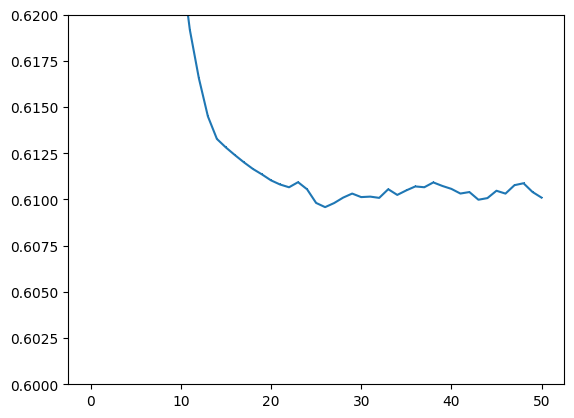

In [17]:
plt.plot(range(start, min(stop, start + len(plaquette))), plaquette, ",-")
plt.ylim(0.6, 0.62)